In [1]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Variáveis

In [2]:
ALPHA_ORDER = [0.1, 0.3, 1.0]
CP_ORDER    = [25, 125]
VAL_ORDER   = [5, 10, 20]  # para bcp/acp
SEED = [1,2,3]

DIR_PATTERN = re.compile(
    r"^fedavg_random_twophase_BCP_(?P<bcp>5|10|20)_ACP_(?P<acp>5|10|20)_CP_(?P<cp>25|125)_"
    r"battery_False_dataset_cifar10_dir_(?P<alpha>0\.1|0\.3|1\.0)_seed_(?P<seed>1|2|3)$"
)

ROOT = Path("/home/filipe/Workspace/dynff/results/motivational/exp-3/mobilenet/two_phase_all").expanduser().resolve()
OUTPUT = Path("/home/filipe/Workspace/dynff/experiments/motivational/figs").expanduser().resolve()
OUTPUT.mkdir(parents=True, exist_ok=True)

# Funções Auxiliares

In [14]:
def read_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Falha ao ler {path}: {e}")
        return None

def parse_round_key_to_idx(k: str) -> int:
    """Chaves vêm deslocadas em +1: '1' -> rodada 0, '2' -> rodada 1, ..."""
    try:
        return int(k) - 1
    except Exception:
        return None

def smooth_series(y: np.ndarray, method="rolling", window=7, polyorder=2) -> np.ndarray:
    """
    Suaviza uma série 1D.
    - method="rolling": média móvel centrada
    - method="savgol": filtro Savitzky–Golay (janela ímpar; polyorder < janela)
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0 or window <= 1:
        return y

    window = int(window)
    if method == "rolling":
        return pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

    # Savitzky–Golay
    if window % 2 == 0:
        window += 1
    polyorder = max(1, min(int(polyorder), window - 1))
    try:
        from scipy.signal import savgol_filter
        return savgol_filter(y, window_length=window, polyorder=polyorder, mode="interp")
    except Exception as e:
        print(f"[WARN] Savitzky–Golay indisponível ({e}). Usando rolling.")
        return pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()

def collect_twophase_runs(root_dir: str) -> pd.DataFrame:
    """
    Lê todos os subdiretórios válidos e retorna um DataFrame 'long' com:
    columns = round, alpha, cp, bcp, acp, cen_accuracy
    """
    root = Path(root_dir).expanduser().resolve()
    records = []

    for child in root.iterdir():
        if not child.is_dir():
            continue
        m = DIR_PATTERN.match(child.name)
        if not m:
            continue

        bcp   = int(m.group("bcp"))
        acp   = int(m.group("acp"))
        cp    = int(m.group("cp"))
        alpha = float(m.group("alpha"))

        mp = read_json(child / "model_performance.json")
        if mp is None:
            print(f"[WARN] Ignorando {child} por falta de model_performance.json válido.")
            continue

        for rk, vals in mp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            acc = vals.get("cen_accuracy", None)
            if acc is None:
                continue
            records.append({
                "round": ridx,
                "alpha": alpha,
                "cp": cp,
                "bcp": bcp,
                "acp": acp,
                "cen_accuracy": float(acc),
            })

    df = pd.DataFrame(records)
    if df.empty:
        print("[ERRO] Nenhum dado encontrado.")
        return df

    return df.sort_values(["cp", "alpha", "bcp", "acp", "round"]).reset_index(drop=True)

# def plot_twophase_accuracy_grid(
#     df_long: pd.DataFrame,
#     outdir="twophase_out",
#     save_pdf_name="twophase_accuracy_grid.pdf",
#     smooth=True,
#     method="rolling",   # "rolling" ou "savgol"
#     window=7,
#     polyorder=2,
#     show=True
# ):
#     """
#     Grade 2×3:
#       - linhas: cp in [25, 125]
#       - colunas: alpha in [0.1, 0.3, 1.0]
#     Em cada subplot: uma linha por combinação (bcp, acp).
#     Linha vertical na rodada cp. Legenda acima e centralizada.
#     """
#     if df_long.empty:
#         print("[ERRO] DataFrame vazio.")
#         return None
# 
#     outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
# 
#     cps    = [c for c in CP_ORDER    if c in df_long["cp"].unique()]
#     alphas = [a for a in ALPHA_ORDER if a in df_long["alpha"].unique()]
# 
#     # todas as combinações (bcp, acp) existentes para mapear cores/legendas
#     combos = (
#         df_long[["bcp","acp"]]
#         .drop_duplicates()
#         .sort_values(["bcp","acp"], key=lambda s: s.map({v:i for i,v in enumerate(VAL_ORDER)}))
#         .itertuples(index=False, name=None)
#     )
#     combos = list(combos)
#     # mapa de cores (consistente em todos os subplots)
#     base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6'])
#     color_map = {combo: base_colors[i % len(base_colors)] for i, combo in enumerate(combos)}
#     labels_map = {combo: f"BCP={combo[0]}, ACP={combo[1]}" for combo in combos}
# 
#     nrows, ncols = len(cps), len(alphas)
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
# 
#     if nrows == 1 and ncols == 1:
#         axes = np.array([[axes]])
#     elif nrows == 1:
#         axes = np.array([axes])
#     elif ncols == 1:
#         axes = np.array([[ax] for ax in axes])
# 
#     handles_for_legend, labels_for_legend = [], []
#     first_handle_done = set()
# 
#     # limites globais pra eixo x
#     rmin = int(df_long["round"].min())
#     rmax = int(df_long["round"].max())
# 
#     for i, cp in enumerate(cps):
#         for j, alpha in enumerate(alphas):
#             ax = axes[i, j]
#             ax.set_title(rf"$\alpha = {alpha}$  |  $cp = {cp}$", fontsize=11)
# 
#             # vertical no cp
#             ax.axvline(cp, color="k", linestyle="--", linewidth=1, zorder=1)
# 
#             # cada combinação (bcp, acp)
#             for combo in combos:
#                 bcp, acp = combo
#                 sub = df_long[(df_long["cp"] == cp) & (df_long["alpha"] == alpha) &
#                               (df_long["bcp"] == bcp) & (df_long["acp"] == acp)]
#                 if sub.empty:
#                     continue
#                 sub = sub.sort_values("round")
#                 x = sub["round"].to_numpy()
#                 y = sub["cen_accuracy"].to_numpy()
#                 y_plot = smooth_series(y, method=method, window=window, polyorder=polyorder) if smooth else y
# 
#                 ln, = ax.plot(x, y_plot, linewidth=2, color=color_map[combo])  # sem marcadores
#                 # pegar handle uma vez por combo
#                 if combo not in first_handle_done:
#                     handles_for_legend.append(ln)
#                     labels_for_legend.append(labels_map[combo])
#                     first_handle_done.add(combo)
# 
#             ax.set_xlim(rmin, rmax)
#             if i == nrows - 1:
#                 ax.set_xlabel("Rounds")
#             if j == 0:
#                 ax.set_ylabel("Test Accuracy")
#             ax.grid(True, linestyle="--", alpha=0.3)
# 
#     # legenda acima e centralizada
#     fig.tight_layout(rect=[0, 0, 1, 0.88])
#     fig.legend(handles_for_legend, labels_for_legend, loc="upper center",
#                ncol=min(len(labels_for_legend), 4), title="Combinações (bcp, acp)",
#                frameon=False)
# 
#     outpath = outdir / save_pdf_name
#     fig.savefig(outpath, format="pdf", bbox_inches="tight")
# 
#     if show:
#         plt.show()
#     else:
#         plt.close(fig)
#     return outpath
# def plot_twophase_grid_rows_cp_cols_bcp(
#     df_long: pd.DataFrame,
#     outdir="twophase_out",
#     save_pdf_name="twophase_grid_cp_bcp.pdf",
#     smooth=True,
#     method="rolling",   # "rolling" | "savgol"
#     window=7,
#     polyorder=2,
#     alpha_agg="mean",   # "mean" | "median"
#     show=True
# ):
#     """
#     Gera uma grade 2×3:
#       - linhas: cp = 25, 125
#       - colunas: bcp = 5, 10, 20
#     Em cada subplot: UMA linha por ACP (cores distintas por (bcp, acp)),
#     onde a série é agregada sobre todos os alphas disponíveis (alpha_agg).
# 
#     - Não compartilha eixo-x.
#     - Sem título global; colunas rotuladas como 'BCP = <valor>'.
#     - Linha vertical em x = cp.
#     - Legenda acima e centralizada.
#     """
#     if df_long.empty:
#         print("[ERRO] DataFrame vazio.")
#         return None
# 
#     outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
# 
#     cps  = [c for c in CP_ORDER  if c in df_long["cp"].unique()]
#     bcps = [b for b in VAL_ORDER if b in df_long["bcp"].unique()]
# 
#     # combos (bcp, acp) existentes para cores estáveis
#     combos = (
#         df_long[["bcp","acp"]]
#         .drop_duplicates()
#         .sort_values(["bcp","acp"], key=lambda s: s.map({v:i for i,v in enumerate(VAL_ORDER)}))
#         .itertuples(index=False, name=None)
#     )
#     combos = list(combos)
# 
#     base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6'])
#     color_map = {combo: base_colors[i % len(base_colors)] for i, combo in enumerate(combos)}
#     label_map = {combo: f"BCP={combo[0]}, ACP={combo[1]}" for combo in combos}
# 
#     nrows, ncols = len(cps), len(bcps)
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5*ncols, 3.2*nrows),
#                              sharex=False, sharey=True)
# 
#     # garantir estrutura de matriz
#     if nrows == 1 and ncols == 1:
#         axes = np.array([[axes]])
#     elif nrows == 1:
#         axes = np.array([axes])
#     elif ncols == 1:
#         axes = np.array([[ax] for ax in axes])
# 
#     handles, labels = [], []
#     got_handle = set()
# 
#     # limites globais de y para consistência visual
#     y_min = df_long["cen_accuracy"].min()
#     y_max = df_long["cen_accuracy"].max()
# 
#     for i, cp in enumerate(cps):
#         for j, bcp in enumerate(bcps):
#             ax = axes[i, j]
# 
#             # título apenas com BCP na linha do topo
#             if i == 0:
#                 ax.set_title(f"BCP = {bcp}", fontsize=11)
# 
#             # linha vertical em cp
#             ax.axvline(cp, color="k", linestyle="--", linewidth=1, zorder=1)
# 
#             # para cada ACP existente nessa coluna
#             acps_here = sorted(df_long[(df_long["cp"] == cp) & (df_long["bcp"] == bcp)]["acp"].unique(),
#                                key=lambda v: {v:i for i,v in enumerate(VAL_ORDER)}.get(v, 999))
# 
#             for acp in acps_here:
#                 # agrega sobre alphas por round
#                 sub = df_long[(df_long["cp"] == cp) & (df_long["bcp"] == bcp) & (df_long["acp"] == acp)]
#                 if sub.empty:
#                     continue
#                 # agregação por round (sobre alpha)
#                 if alpha_agg == "median":
#                     agg = sub.groupby("round", as_index=False)["cen_accuracy"].median()
#                 else:  # mean
#                     agg = sub.groupby("round", as_index=False)["cen_accuracy"].mean()
# 
#                 x = agg["round"].to_numpy()
#                 y = agg["cen_accuracy"].to_numpy()
#                 y_plot = smooth_series(y, method=method, window=window, polyorder=polyorder) if smooth else y
# 
#                 ln, = ax.plot(x, y_plot, linewidth=2, color=color_map[(bcp, acp)])
#                 combo = (bcp, acp)
#                 if combo not in got_handle:
#                     handles.append(ln)
#                     labels.append(label_map[combo])
#                     got_handle.add(combo)
# 
#             # rótulos e limites
#             ax.set_ylim(y_min, y_max)
#             ax.set_xlabel("Rounds")
#             if j == 0:
#                 ax.set_ylabel("Test Accuracy")
#             ax.grid(True, linestyle="--", alpha=0.3)
# 
#     # legenda acima e centralizada
#     fig.tight_layout(rect=[0, 0, 1, 0.88])
#     fig.legend(handles, labels, loc="upper center",
#                ncol=min(len(labels), 4), title="(BCP, ACP)",
#                frameon=False)
# 
#     outpath = outdir / save_pdf_name
#     fig.savefig(outpath, format="pdf", bbox_inches="tight")
# 
#     if show:
#         plt.show()
#     else:
#         plt.close(fig)
#     return outpath

def plot_twophase_grid_rows_cp_cols_bcp(
    df_long: pd.DataFrame,
    outdir="twophase_out",
    save_pdf_name="twophase_grid_cp_bcp.pdf",
    smooth=True,
    method="rolling",   # "rolling" | "savgol"
    window=7,
    polyorder=2,
    alpha_agg="mean",   # "mean" | "median"
    show=True,
    overlay_diag_all=True,      # <<< NOVO: sobrepor BCP=ACP em TODOS os subplots
    overlay_alpha=0.65,         # <<< sólido, sem pontilhado
    overlay_linewidth=1.6
):
    """
    Grade 2×3 (linhas: cp; colunas: bcp). Em cada subplot:
      - Curvas "locais" para cada ACP daquele (cp,bcp)
      - (Opcional) Sobrepõe as curvas da diagonal (BCP=ACP) do mesmo cp em TODAS as colunas.

    Sem compartilhamento de eixo-x, com linha vertical em x=cp e
    legenda única no topo.
    """
    if df_long.empty:
        print("[ERRO] DataFrame vazio.")
        return None

    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    cps  = [c for c in CP_ORDER  if c in df_long["cp"].unique()]
    bcps = [b for b in VAL_ORDER if b in df_long["bcp"].unique()]

    # Combos (bcp, acp) existentes para cores estáveis
    combos = (
        df_long[["bcp","acp"]]
        .drop_duplicates()
        .sort_values(["bcp","acp"], key=lambda s: s.map({v:i for i,v in enumerate(VAL_ORDER)}))
        .itertuples(index=False, name=None)
    )
    combos = list(combos)
    combos_set = set(combos)

    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6'])
    color_map = {combo: base_colors[i % len(base_colors)] for i, combo in enumerate(combos)}
    label_map = {combo: f"BCP={combo[0]}, ACP={combo[1]}" for combo in combos}

    # valores disponíveis para a diagonal (BCP=ACP)
    diag_vals = [b for b in bcps if (b, b) in combos_set]

    # ---------- PRÉ-CÁLCULO das séries (agregação + suavização) ----------
    def _agg_series(sub: pd.DataFrame):
        if alpha_agg == "median":
            agg = sub.groupby("round", as_index=False)["cen_accuracy"].median()
        else:
            agg = sub.groupby("round", as_index=False)["cen_accuracy"].mean()
        x = agg["round"].to_numpy()
        y = agg["cen_accuracy"].to_numpy()
        y = smooth_series(y, method=method, window=window, polyorder=polyorder) if smooth else y
        return x, y

    series_cache = {}  # (cp,bcp,acp) -> (x,y)
    for cp in cps:
        df_cp = df_long[df_long["cp"] == cp]
        for bcp in bcps:
            df_cp_b = df_cp[df_cp["bcp"] == bcp]
            if df_cp_b.empty:
                continue
            for acp in sorted(df_cp_b["acp"].unique(),
                              key=lambda v: {v:i for i,v in enumerate(VAL_ORDER)}.get(v, 999)):
                sub = df_cp_b[df_cp_b["acp"] == acp]
                if sub.empty:
                    continue
                series_cache[(cp, bcp, acp)] = _agg_series(sub)

    nrows, ncols = len(cps), len(bcps)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5*ncols, 3.2*nrows),
                             sharex=False, sharey=True)

    # garantir estrutura de matriz p/ casos degenerados
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])

    handles, labels = [], []
    got_handle = set()

    # limites globais de y
    y_min = df_long["cen_accuracy"].min()
    y_max = df_long["cen_accuracy"].max()

    for i, cp in enumerate(cps):
        for j, bcp in enumerate(bcps):
            ax = axes[i, j]

            if i == 0:
                ax.set_title(f"BCP = {bcp}", fontsize=11)

            ax.axvline(cp, color="k", linestyle="--", linewidth=1, zorder=1)

            # ---- Linhas "locais" (desse bcp) ----
            acps_here = sorted(
                df_long[(df_long["cp"] == cp) & (df_long["bcp"] == bcp)]["acp"].unique(),
                key=lambda v: {v:i for i,v in enumerate(VAL_ORDER)}.get(v, 999)
            )
            for acp in acps_here:
                key = (cp, bcp, acp)
                if key not in series_cache:
                    continue
                x, y = series_cache[key]
                ln, = ax.plot(x, y, linewidth=2, color=color_map[(bcp, acp)], zorder=3)
                combo = (bcp, acp)
                if combo not in got_handle:
                    handles.append(ln)
                    labels.append(label_map[combo])
                    got_handle.add(combo)

            # ---- Sobrepor a DIAGONAL (BCP=ACP) deste CP em TODAS as colunas ----
            if overlay_diag_all and len(diag_vals) > 0:
                for d in diag_vals:
                    if d == bcp:
                        # já foi traçada como "local" nesta coluna
                        continue
                    key_d = (cp, d, d)
                    if key_d not in series_cache:
                        continue
                    xd, yd = series_cache[key_d]
                    ax.plot(
                        xd, yd,
                        linewidth=overlay_linewidth,
                        alpha=overlay_alpha,
                        color=color_map[(d, d)],
                        zorder=2
                    )

            ax.set_ylim(y_min, y_max)
            ax.set_xlabel("Rounds")
            if j == 0:
                ax.set_ylabel("Test Accuracy")
            ax.grid(True, linestyle="--", alpha=0.3)

    fig.tight_layout(rect=[0, 0, 1, 0.88])
    fig.legend(handles, labels, loc="upper center",
               ncol=min(len(labels), 4), title="(BCP, ACP)",
               frameon=False)

    outpath = Path(outdir) / save_pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


# Performance

In [12]:
df_two = collect_twophase_runs(ROOT)

# Gráfico

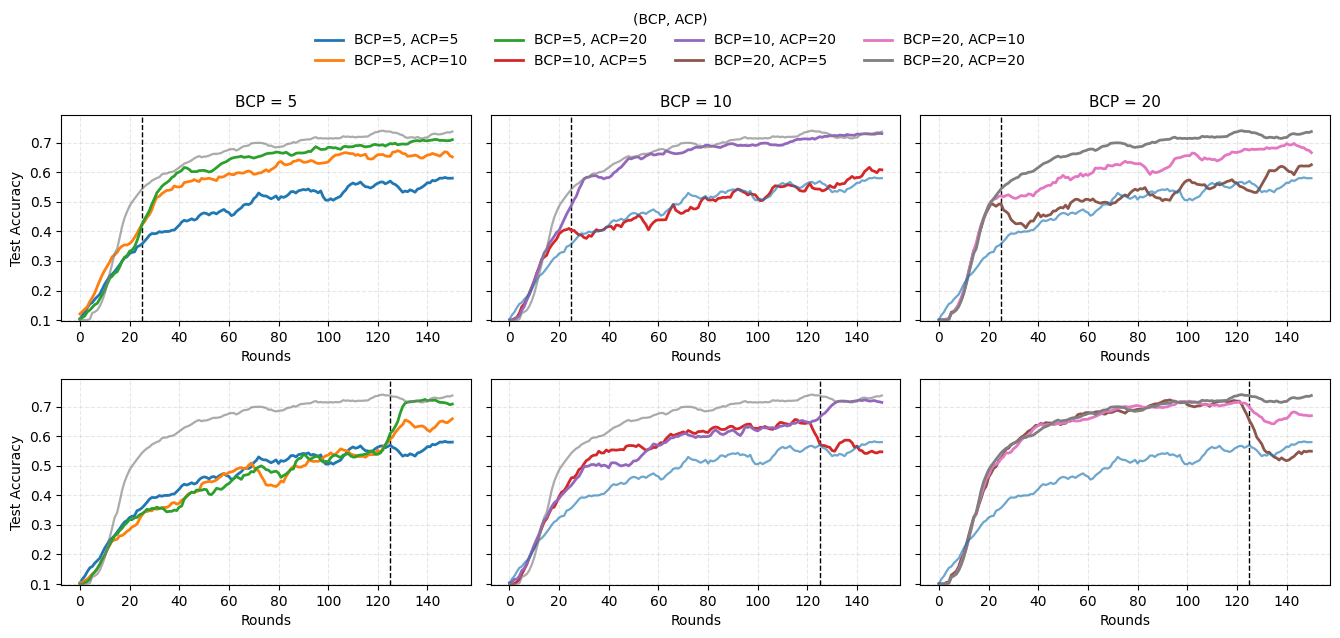

In [15]:
pdf_path = plot_twophase_grid_rows_cp_cols_bcp(
    df_two,
    outdir=OUTPUT,
    save_pdf_name="twophase_accuracy_grid_smoothed.pdf",
    smooth=True,        # habilita suavização
    method="rolling",   # "rolling" ou "savgol"
    window=10,           # janela p/ média móvel (ou Savitzky–Golay)
    polyorder=2,        # usado apenas se method="savgol"
    show=True
)

# Takeaways

A ausência de dados relevantes no treino, causada pela redução drástica de clientes selecionados nas rodadas iniciais, afeta a evolução do modelo nos períodos críticos e de saturação. Porém, como observado nas colunas, a mudança após a estabilidade é suficiente para que as curvas se assemelhem à curva do aprendizado de participação constante com o valor final.
    

| Energia\Rrodadas |                       Fixas                        |                                   Alvo                                   |
|:----------------:|:--------------------------------------------------:|:------------------------------------------------------------------------:|
|   Com economia   | Menos no início + aumenta ao final + balanceamento | Aumento de participação iterativo + balanceamento por consumo de energia |
|   Sem economia   |         Menos no início + aumenta ao final         |                      Participação máxima permitida                       |